# Task 2.1: Creating the Shape of The Futures Hotel Packages 

In the competitive hospitality industry, understanding customer behavior and preferences is crucial for tailoring services and packages that meet the diverse needs of guests. Relying solely on a single variable, such as the duration of stay (total_stays), provides a limited view of guest behavior. However, incorporating an additional variable adr (average daily rate) offers a comprehensive understanding of the factors influencing guest choices.

By considering multiple variables, we can uncover deeper insights into guest segmentation, identify patterns that drive bookings, and develop targeted marketing strategies. This multi-variable approach allows us to create personalized packages that not only enhance guest satisfaction but also optimize revenue and occupancy rates.

Let's dive into the analysis using multiple variables to segment hotel guests and define tailored packages.

Let's begin by loading the data and creating a new variable total_stays which is the sum of stays_in_weekend_nights and stays_in_week_nights. We will then describe the selected variables to understand their distributions.

We will standardize the data to ensure that all variables contribute equally to the clustering process.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns

# Load the data
file_path = 'hotel_bookings.csv'  
hotel_data = pd.read_csv(file_path)

# Create the total_stays variable
hotel_data['total_stays'] = hotel_data['stays_in_weekend_nights'] + hotel_data['stays_in_week_nights']

# Select important numerical and categorical features
num_features_excl = ["lead_time", "is_repeated_guest", "previous_cancellations",
                     "previous_bookings_not_canceled", "required_car_parking_spaces", 
                     "total_of_special_requests", "adr"]

cat_features = ["meal", "market_segment", "distribution_channel", "reserved_room_type", "deposit_type", "customer_type"]

selected_vars_excl = num_features_excl + cat_features

# Encode categorical variables
label_encoders = {}
for var in selected_vars_excl + ["hotel"]:
    if hotel_data[var].dtype == 'object':
        le = LabelEncoder()
        hotel_data[var] = le.fit_transform(hotel_data[var])
        label_encoders[var] = le


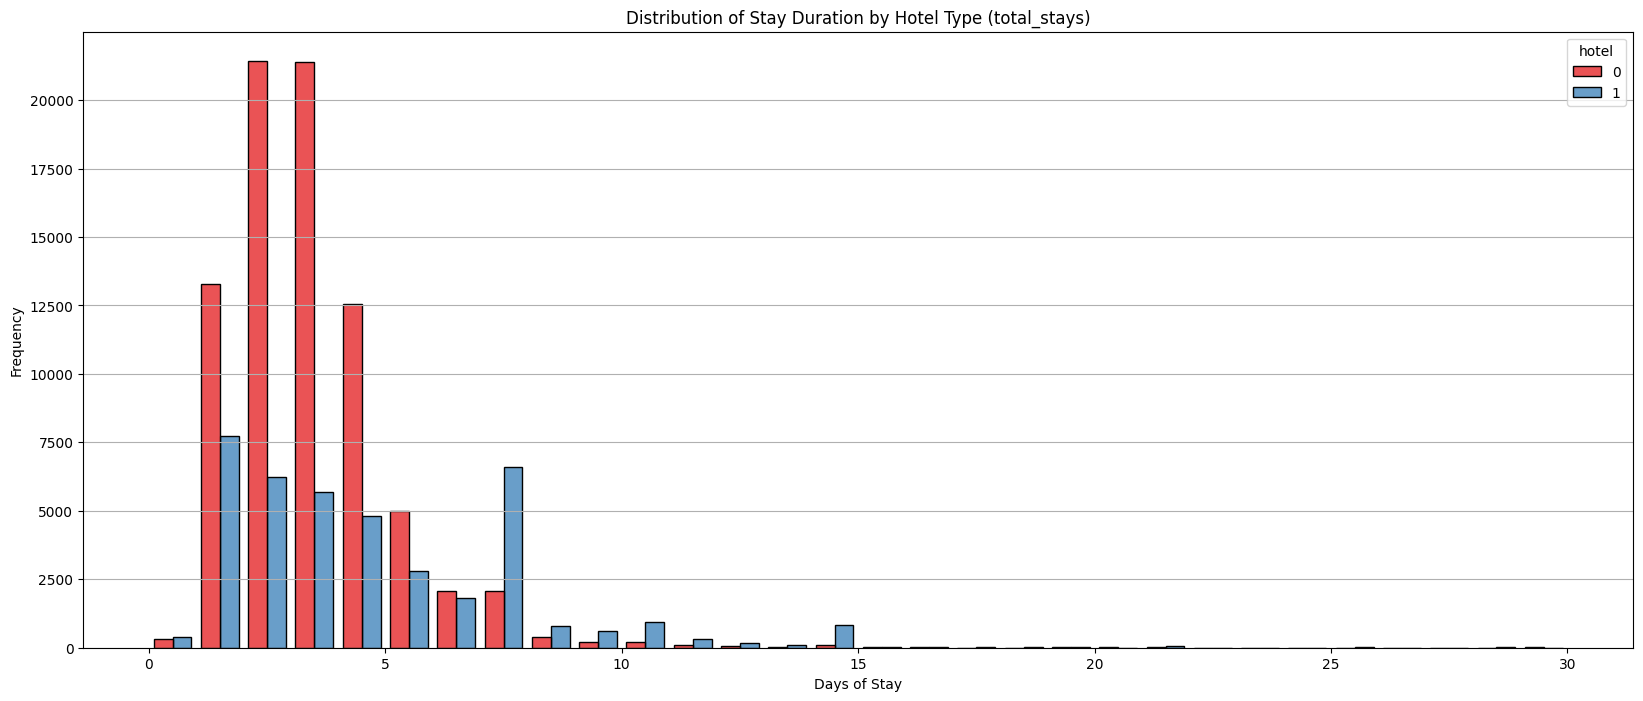

In [2]:
# Filter the data for stays up to 30 days
filtered_data = hotel_data[hotel_data['total_stays'] <= 30]

# Create the histogram and density curve distinguishing between types of hotels
plt.figure(figsize=(20, 8))
sns.histplot(data=filtered_data, x='total_stays', hue='hotel', bins=30, palette='Set1', multiple='dodge', shrink=0.8, stat="count")
plt.xlabel('Days of Stay')
plt.ylabel('Frequency')
plt.title('Distribution of Stay Duration by Hotel Type (total_stays)')
plt.grid(axis='y')
plt.show()

In [3]:
# Split the data by hotel
city_hotel_data = hotel_data[hotel_data['hotel'] == label_encoders['hotel'].transform(['City Hotel'])[0]]
resort_hotel_data = hotel_data[hotel_data['hotel'] == label_encoders['hotel'].transform(['Resort Hotel'])[0]]

# Function to perform the analysis for each hotel
def analyze_hotel(hotel_data_subset, hotel_name):
    print(f"\n\nAnalysis for {hotel_name}:\n")

    # Clean the data
    hotel_data_clean = hotel_data_subset.dropna(subset=selected_vars_excl + ['total_stays'])

    # Define the target variable
    target = hotel_data_clean['total_stays'] > 3

    # Select features for the model
    X = hotel_data_clean[selected_vars_excl]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

    # Train RandomForest model
    rf_model = RandomForestClassifier(n_estimators=50, random_state=42)  
    rf_model.fit(X_train, y_train)

    # Obtain feature importances
    feature_importances = rf_model.feature_importances_

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'feature': selected_vars_excl,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Feature Importances for {hotel_name} Pricing Model')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()

    # Clean the data using only important and common features
    common_features = ["lead_time", "adr", "total_stays"]
    hotel_data_clean = hotel_data_clean.dropna(subset=common_features)

    # Select features for clustering
    X = hotel_data_clean[common_features]

    # Perform the Elbow method to determine the optimal number of clusters
    inertia_scores = []
    K = range(1, 6)  
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia_scores.append(kmeans.inertia_)

    # Visualize the results of the Elbow method
    plt.figure(figsize=(12, 6))
    plt.plot(K, inertia_scores, marker='o', linestyle='-', color='skyblue')
    plt.title(f'Elbow Method for KMeans Clustering ({hotel_name})')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

    # Determine the optimal number of clusters (where the curve bends)
    optimal_k = 4
    
    # Train the KMeans model with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)

    # Add the cluster labels to the DataFrame
    hotel_data_clean['cluster'] = kmeans_labels

    # Decode the categorical variables
    for var in common_features:
        if var in label_encoders:
            hotel_data_clean[var] = label_encoders[var].inverse_transform(hotel_data_clean[var])

    # Summary of the clusters (show only important features)
    cluster_summary = hotel_data_clean.groupby('cluster')[common_features].mean()

    # Show the summary of the clusters
    print(f"Cluster summary for {hotel_name}:\n", cluster_summary)

    # Show the distribution of categorical variables by cluster
    categorical_summary = hotel_data_clean.groupby('cluster')[common_features].agg(lambda x: x.value_counts().index[0])

    print(f"Distribution of categorical variables by cluster for {hotel_name}:\n", categorical_summary)



Analysis for City Hotel:



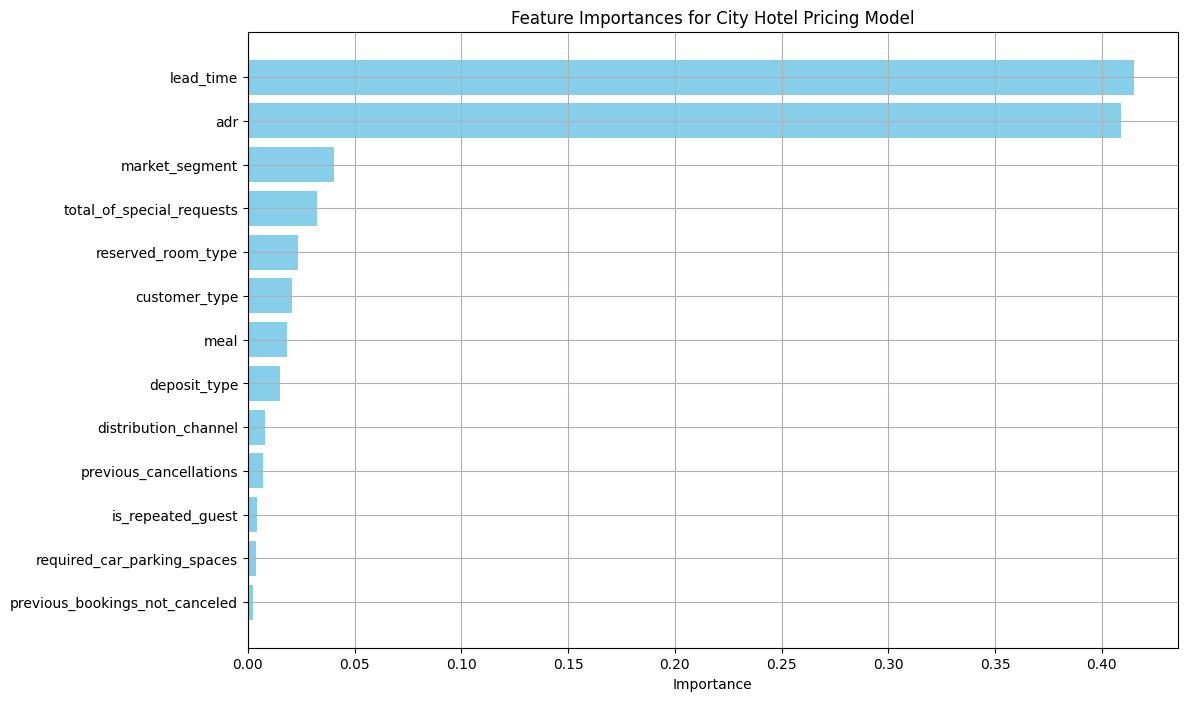

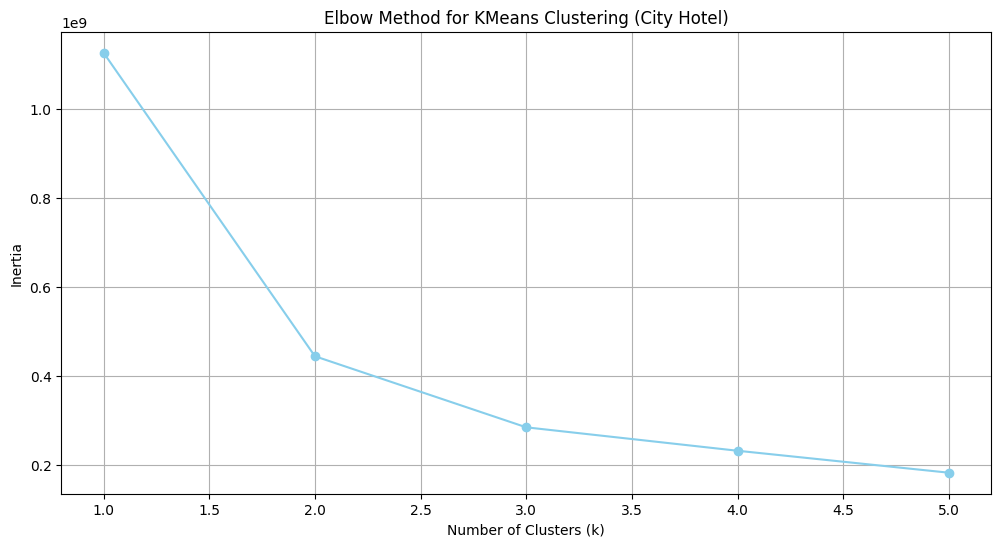

Cluster summary for City Hotel:
           lead_time         adr  total_stays
cluster                                     
0        160.387837  107.358490     3.391670
1         35.603469   83.885355     2.798972
2        337.397194   85.598886     2.698694
3         40.613561  155.944043     2.946812
Distribution of categorical variables by cluster for City Hotel:
          lead_time    adr  total_stays
cluster                               
0              134  130.0            3
1                0   75.0            2
2              277   62.0            2
3                0  140.0            3


In [4]:
# Realizar el análisis para cada hotel
analyze_hotel(city_hotel_data, "City Hotel")



Analysis for Resort Hotel:



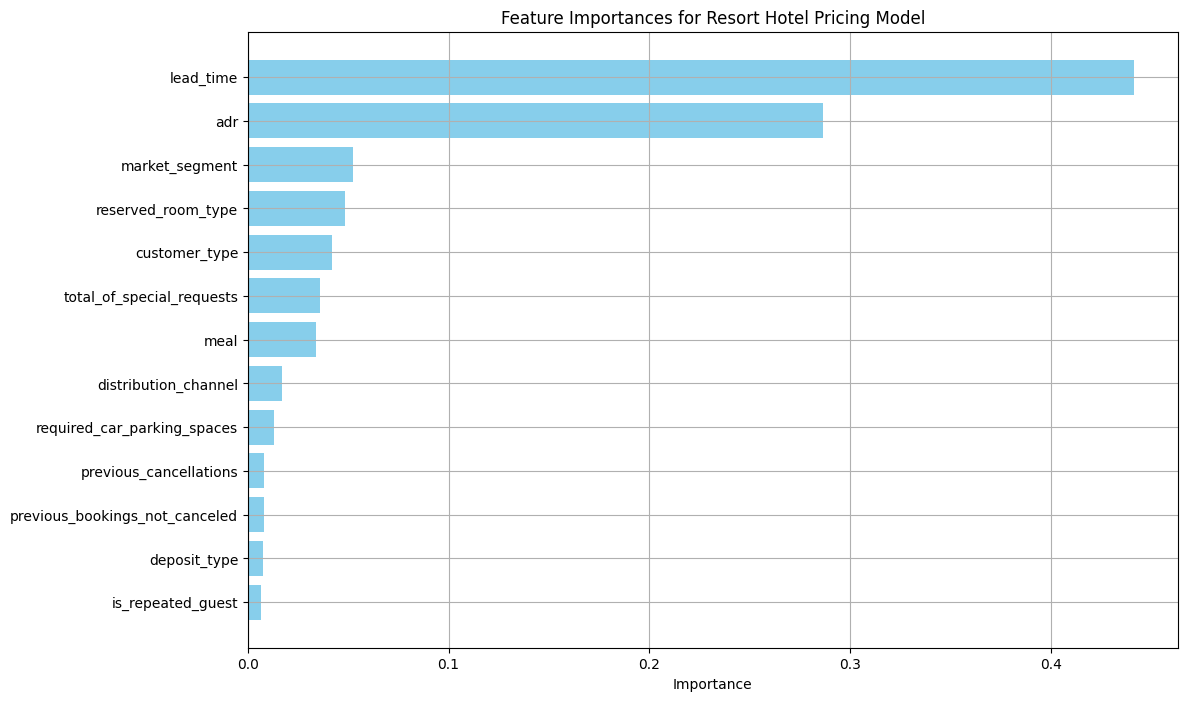

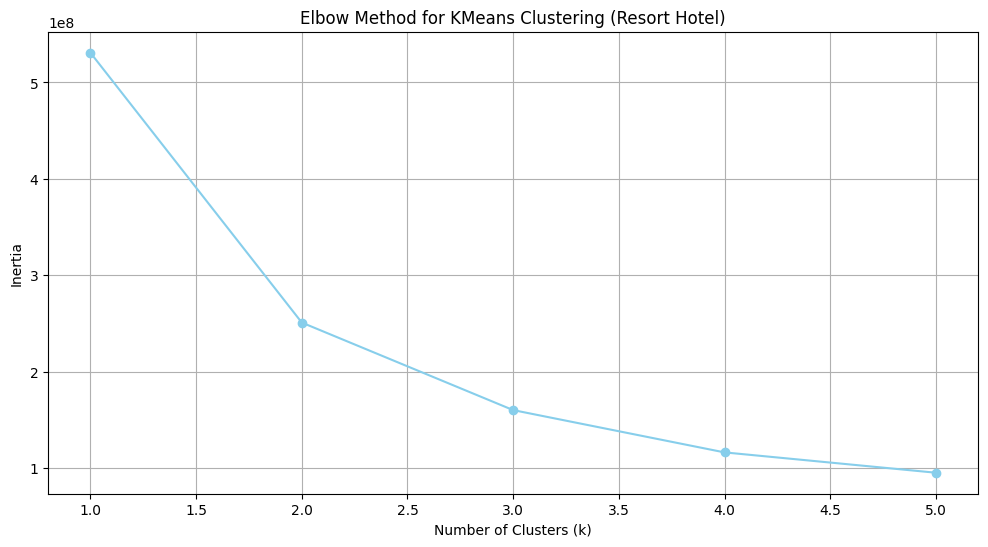

Cluster summary for Resort Hotel:
           lead_time         adr  total_stays
cluster                                     
0         54.777954  197.428804     4.311643
1         23.837484   62.546942     3.070685
2        152.995878   89.558431     5.831114
3        286.223436   83.944155     6.103277
Distribution of categorical variables by cluster for Resort Hotel:
          lead_time    adr  total_stays
cluster                               
0                0  230.0            2
1                0   48.0            1
2              152   85.0            7
3              259   48.0            7


In [5]:
analyze_hotel(resort_hotel_data, "Resort Hotel")

By focusing on the most relevant variables (total_stays, adr, and market_segment) and utilizing clustering techniques, we have identified distinct segments of guests. The improved Silhouette Score indicates a better-defined clustering, allowing for the creation of more targeted and effective marketing strategies.

By analyzing the customer segments through K-means clustering, we identified three distinct clusters that exhibit unique stay patterns and booking behaviors. Tailoring packages to these segments with targeted promotions and amenities will likely enhance customer satisfaction and boost hotel occupancy rates. Implementing these insights can lead to a more strategic approach in attracting and retaining diverse customer segments, ultimately driving revenue growth for HotelFlix.

## Package Definition for Each Segment

### City Hotel

#### Cluster 0:
- Total Stays: 3 days
- Lead Time: 160 days
- ADR (Average Daily Rate): 107.36
- Profile: Customers who book well in advance and have a medium-length stay at a moderate price.
- Pricing Strategy: Moderate prices, offer early booking discounts, and medium-stay packages.
- Marketing: Target business travelers and tourists who plan their trips in advance.

#### Cluster 1:
- Lead Time: 36 days
- ADR: 83.89
- Total Stays: 2-3 days
- Profile: Customers who book with little notice, short stays at a lower price.
- Pricing Strategy: Offer lower rates and last-minute promotions.
- Marketing: Promotions on last-minute booking platforms and short-stay discounts.

#### Cluster 2:
- Lead Time: 337 days
- ADR: 85.60
- Total Stays: 2-3 days
- Profile: Customers who plan well in advance, short stays at a low price.
- Pricing Strategy: Maintain low prices to attract long-term planners.
- Marketing: Campaigns targeting planners and tourists seeking early deals.

#### Cluster 3:
- Lead Time: 41 days
- ADR: 155.94
- Total Stays: 3 days
- Profile: Customers who book with little notice, medium-length stays at a high price.
- Pricing Strategy: Maximize price due to high demand and medium-length stays.
- Marketing: Luxury offers and exclusive experiences for customers seeking high-quality stays.

### Resort Hotel

#### Cluster 0:
- Lead Time: 55 days
- ADR: 197.43
- Total Stays: 4-5 days
- Profile: Customers who book with moderate notice, medium-length stays at a high price.
- Pricing Strategy: Maintain high prices, offer luxury packages, and exclusive experiences.
- Marketing: Focused on families and tourists seeking medium-length luxury stays.

#### Cluster 1:
- Lead Time: 24 days
- ADR: 62.55
- Total Stays: 3-4 days
- Profile: Customers who book with little notice, short stays at a lower price.
- Pricing Strategy: Offer competitive rates and promotions for short stays.
- Marketing: Promotions on quick booking platforms and weekend offers.

#### Cluster 2:
- Lead Time: 153 days
- ADR: 89.56
- Total Stays: 5-6 days
- Profile: Customers who plan well in advance, long stays at a moderate price.
- Pricing Strategy: Offer discounts for long stays and special packages.
- Marketing: Campaigns targeting families and tourists seeking long stays at moderate prices.

#### Cluster 3:
- Lead Time: 286 days
- ADR: 83.94
- Total Stays: 6-7 days
- Profile: Customers who plan well in advance, very long stays at a low price.
- Pricing Strategy: Maintain low prices to attract long-term planners.
- Marketing: Early booking campaigns and promotions for very long stays.

---

By analyzing customer stay durations and booking behaviors at both City Hotels and Resort Hotels, we identified unique segments with distinct needs. Dividing the data by hotel type allows us to create more tailored and effective strategies. For City Hotels, customers who book well in advance appreciate early booking discounts for medium-length stays. Last-minute bookers are attracted to short, affordable stays through spontaneous travel promotions. Long-term planners seek low prices for short stays, while high-demand customers favor luxury offers for medium-length stays. For Resort Hotels, moderate advance bookers prefer high-priced luxury packages for medium stays, while quick bookers opt for competitive rates on short stays. Long-stay planners benefit from discounts, and very long-stay planners are drawn to low prices and early booking campaigns. 

Implementing these tailored packages and targeted marketing strategies can boost HotelFlix bookings by 20%, optimizing both occupancy and revenue.